### Import Libraries

In [49]:
import datetime 
import functions14
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (recall_score, precision_score, precision_recall_curve, 
                             roc_curve, confusion_matrix, auc, f1_score, 
                             balanced_accuracy_score, roc_auc_score, plot_confusion_matrix, make_scorer)
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix
from numpy import arange
from numpy import argmax
from numpy import argmin
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
import re
import time

### Define Functions

In [96]:
def merge_test_set(X_test, y_test, y_pred):
    X_test = X_test.reset_index()
    y_test = y_test.reset_index()
    y_pred = y_pred.reset_index()
    test_df = pd.concat([X_test, y_test, y_pred], axis=1)
    return pd.DataFrame(test_df)

def calculate_insurance(stock_value):
    if stock_value < 500:
        return 1.73
    if 500 <= stock_value < 1000:
        return 3.46
    if 1000 <= stock_value < 1500:
        return 5.19
    if 1500 <= stock_value < 2000:
        return 6.92
    if 2000 <= stock_value < 2500:
        return 8.65
    if 2500 <= stock_value < 3000:
        return 10.38
    if 3000 <= stock_value < 3500:
        return 12.11
    if 3500 <= stock_value < 4000:
        return 13.84
    if 4000 <= stock_value < 4500:
        return 15.57
    if 4500 <= stock_value < 5000:
        return 17.30
    if stock_value >= 5000: 
        return 19.03
    
def determine_misclass(pred, lost):
    if pred == 1 and lost == 1:
        misclass = 'TP'
    if pred == 1 and lost == 0:
        misclass= 'FP'
    if pred == 0 and lost == 1:
        misclass = 'FN'
    if pred== 0 and lost == 0:
        misclass = 'TN'
    return misclass 

def determine_misclass_cost(classification, stock_value):
    if classification == 'FP':
        return calculate_insurance(stock_value)
    if classification == 'FN':
        return stock_value
    else:
        return 0
    
    
def cost_test_set(X_test, y_test, y_pred):
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns.values[0] = 'Pred'
    test_df = merge_test_set(X_test['stock_value'], y_test, y_pred)
    test_df['classification'] = test_df.apply(lambda x: determine_misclass(x.Pred, x.Is_lost_item), axis=1)
    test_df['misclass_cost'] = test_df.apply(lambda x: determine_misclass_cost(x.classification, x.stock_value), axis=1)
    return np.sum(test_df['misclass_cost'])


def change_input_data(X_train_transformed, X_validate_transformed, X_test_transformed, y_test, y_validate, number_of_features):
    FS_most = list(most_important_features)
    feats = FS_most[:number_of_features]
    X_train_transformed = X_train_transformed[feats]
    X_validate_transformed = X_validate_transformed[feats]
    X_test_transformed = X_test_transformed[feats]
    
    X_train_transformed = pd.DataFrame(X_train_transformed)
    X_validate_transformed = pd.DataFrame(X_validate_transformed)
    X_test_transformed = pd.DataFrame(X_test_transformed)
    
    y_validate =pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)
    
    return X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test

def evaluate_classifier_CV(model, X_train, y_train, SVM=False):
    skf = StratifiedKFold(n_splits=3)
    recalls = []
    precisions = []
    costs = []
    ROC_AUCs = []
    balanced_accuracys = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        recalls.append(recall_score(y_test_fold, y_pred_fold, average="binary", pos_label=1))
        precisions.append(precision_score(y_test_fold, y_pred_fold, average="binary", pos_label=1))
        costs.append(functions14.calculate_cost(y_test_fold, y_pred_fold))
        balanced_accuracys.append(balanced_accuracy_score(y_test_fold, y_pred_fold))
        if SVM == True:
            ROC_AUCs.append(0)
        if SVM == False:
            y_pred_proba = model.predict_proba(X_test_fold)
            ROC_AUCs.append(roc_auc_score(y_test_fold, y_pred_proba[:, 1])) 
        plot_confusion_matrix(model, X_test_fold, y_test_fold)
        plt.show()
    
    recall = np.mean(recalls)
    precision = np.mean(precisions)
    cost = np.mean(costs)
    ROC_AUC= np.mean(ROC_AUCs)
    balanced_accuracy = np.mean(balanced_accuracys)
    print('CV RESULTS: Recall = {}, Precision = {}, ROC_AUC = {}, Costs are {}, Balanced Accuracy = {}'.format(recall, precision, ROC_AUC, cost, balanced_accuracy))
    print('Stdev CV results: Recall stdev = {}, precision stdev = {}, Balanced Accuracy stdev = {}, ROC_AUC stdev = {}'.format(np.std(recalls), np.std(precisions), np.std(balanced_accuracys), np.std(ROC_AUCs)))
    return recalls, precisions, costs, ROC_AUCs

def evaluate_classifier_test(model, X_train, y_train, X_test, y_test, SVM=False):    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ROC_AUC_test = 0
    if SVM == False:
        y_pred_proba = model.predict_proba(X_test)
        ROC_AUC_test = roc_auc_score(y_test, y_pred_proba[:, 1])
    recall_test = recall_score(y_test, y_pred, average="binary", pos_label=1)
    precision_test = precision_score(y_test, y_pred, average='binary', pos_label = 1)
    balanced_accuracy2 = balanced_accuracy_score(y_test, y_pred)
    cost_test = calculate_cost(y_test, y_pred)
    print(cost_test)
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()
    CM = confusion_matrix(y_test, y_pred)
    print(CM)
    print('Test set results: Recall = {}, Precision = {}, ROC_AUC = {}, balanced accuracy = {},  Costs are {}'.
          format(recall_test, precision_test, ROC_AUC_test, balanced_accuracy2, cost_test))
    
    return model

def calculate_cost(y_true, y_pred, **kwargs):
    CM = confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    #print('TN = {}, TP = {}, FP = {}, FN = {}'.format(TN, TP, FP, FN))
    costs = FN* mean_stock_value + FP*mean_insurance_costs
    #print('Costs are thus {}'.format(costs))
    return costs 

mean_stock_value = 340.18
mean_insurance_costs = 1.68
cost_scorer = make_scorer(calculate_cost, greater_is_better = False)

def find_optimal_parameters(model, param_grid, optimizer, cv, X_validate, y_validate):
    
    random_state=1
    grid_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = optimizer, 
                          cv = cv, n_jobs = -1, verbose = 10)
    grid_search.fit(X_validate, y_validate)
    print(grid_search.best_params_)
    print('best score is ', grid_search.best_score_)
    
    return grid_search.best_params_

def evaluate_DH_performance(model, params, X_validate, y_validate, X_test, y_test):
    
    if model == 'RF':
        model_optimized = RandomForestClassifier(n_estimators = params['n_estimators'], min_samples_split = params['min_samples_split'], 
            max_features = params['max_features'], max_depth = params['max_depth'], criterion = params['criterion'], 
                                                 class_weight = params['class_weight'], random_state=random_state)
    
    if model == 'LR':
        model_optimized = LogisticRegression(penalty = params['penalty'], class_weight = params['class_weight'], 
                                             solver = params['solver'], random_state = random_state)
        
    if model == 'svm':
        model_optimized = SVC(C = params['C'], kernel= params['kernel'], gamma = params['gamma'], 
                              class_weight = params['class_weight'], probability=True, random_state=random_state)
    
    if model == 'XGB':
        model_optimized = XGBClassifier(booster = params['booster'], eta = params['eta'], gamma= params['gamma'], max_depth = params['max_depth'],
                                        sampling_method = params['sampling_method'], tree_method = params['tree_method'], 
                                      scale_pos_weight = params['scale_pos_weight'], random_state=random_state)
    if model == 'knn':
        model_optimized = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights = params['weights'])
        
    if model == 'DT':
        model_optimized = DecisionTreeClassifier(criterion = params['criterion'], max_depth = params['max_depth'], 
                                                min_samples_split = params['min_samples_split'], class_weight= params['class_weight'],
                                                max_features = params['max_features'], random_state=random_state)
    
    #evaluate_classifier_CV(model_optimized, X_validate, y_validate, SVM=False)
    evaluate_classifier_test(model_optimized, X_validate, y_validate, X_test, y_test, SVM=False)  

    return 


def get_outcomes(model, params, X_validate, y_validate, X_test, y_test):
    
    if model == 'RF':
        model_optimized = RandomForestClassifier(n_estimators = params['n_estimators'], min_samples_split = params['min_samples_split'], 
            max_features = params['max_features'], max_depth = params['max_depth'], criterion = params['criterion'], 
                                                 class_weight = params['class_weight'], random_state=random_state)
    
    if model == 'LR':
        model_optimized = LogisticRegression(penalty = params['penalty'], class_weight = params['class_weight'], 
                                             solver = params['solver'], random_state = random_state)
        
    if model == 'svm':
        model_optimized = SVC(C = params['C'], kernel= params['kernel'], gamma = params['gamma'], 
                              class_weight = params['class_weight'], probability=True, random_state=random_state)
    
    if model == 'XGB':
        model_optimized = XGBClassifier(booster = params['booster'], eta = params['eta'], gamma= params['gamma'], max_depth = params['max_depth'],
                                        sampling_method = params['sampling_method'], tree_method = params['tree_method'], 
                                      scale_pos_weight = params['scale_pos_weight'], random_state=random_state)
    if model == 'knn':
        model_optimized = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights = params['weights'])
        
    if model == 'DT':
        model_optimized = DecisionTreeClassifier(criterion = params['criterion'], max_depth = params['max_depth'], 
                                                min_samples_split = params['min_samples_split'], class_weight= params['class_weight'],
                                                max_features = params['max_features'], random_state=random_state)
    
    #evaluate_classifier_CV(model_optimized, X_validate, y_validate, SVM=False)
    evaluate_classifier_test(model_optimized, X_validate, y_validate, X_test, y_test, SVM=False)  
    model_optimized.fit(X_validate, y_validate)
    y_pred = model_optimized.predict(X_test)
    
    return X_test, y_test, y_pred



def make_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted label')
    ax.set_ylabel('Actual label ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad


def merge_test_set(X_test, y_test, y_pred):
    X_test = X_test.reset_index()
    y_test = y_test.reset_index()
    y_pred = y_pred.reset_index()
    test_df = pd.concat([X_test, y_test, y_pred], axis=1)
    return pd.DataFrame(test_df)

def calculate_insurance(stock_value):
    if stock_value < 500:
        return 1.73
    if 500 <= stock_value < 1000:
        return 3.46
    if 1000 <= stock_value < 1500:
        return 5.19
    if 1500 <= stock_value < 2000:
        return 6.92
    if 2000 <= stock_value < 2500:
        return 8.65
    if 2500 <= stock_value < 3000:
        return 10.38
    if 3000 <= stock_value < 3500:
        return 12.11
    if 3500 <= stock_value < 4000:
        return 13.84
    if 4000 <= stock_value < 4500:
        return 15.57
    if 4500 <= stock_value < 5000:
        return 17.30
    if stock_value >= 5000: 
        return 19.03
    
def determine_misclass(pred, lost):
    if pred == 1 and lost == 1:
        misclass = 'TP'
    if pred == 1 and lost == 0:
        misclass= 'FP'
    if pred == 0 and lost == 1:
        misclass = 'FN'
    if pred== 0 and lost == 0:
        misclass = 'TN'
    return misclass 

def determine_misclass_cost(classification, stock_value):
    if classification == 'FP':
        return calculate_insurance(stock_value)
    if classification == 'FN':
        return stock_value
    else:
        return 0
    
def cost_test_set(X_test, y_test, y_pred):
    y_pred = pd.DataFrame(y_pred)
    #y_pred.set_axis(['Pred'], axis='columns', inplace=False)
    y_test = y_test.astype(int)
    test_df = merge_test_set(X_test['stock_value'], y_test, y_pred)
    test_df['Pred'] = test_df.iloc[:,-1:]
    test_df['stock_value_normal'] = np.exp(test_df["stock_value"]) 
    test_df
    test_df['classification'] = test_df.apply(lambda x: determine_misclass(x.Pred, x.Is_lost_item), axis=1)
    test_df['misclass_cost'] = test_df.apply(lambda x: determine_misclass_cost(x.classification, x.stock_value_normal), axis=1)
    print('Total misclassification costs are ', np.sum(test_df['misclass_cost']))
    print(test_df['classification'].value_counts())
    return np.sum(test_df['misclass_cost'])

In [73]:
#Best params AE RF
best_params_AE_RF = {'n_estimators': 100, 'min_samples_split': 10, 'max_features': None, 'max_depth': 5, 
                     'criterion': 'entropy', 'class_weight': 'balanced'}
best_params_VAE_RF = {'n_estimators': 100, 'min_samples_split': 10, 'max_features': None, 'max_depth': 5, 
                     'criterion': 'entropy', 'class_weight': 'balanced'}
best_params_DAE_RF = {'n_estimators': 100, 'min_samples_split': 10, 'max_features': None, 'max_depth': 5, 
                     'criterion': 'entropy', 'class_weight': 'balanced'}

#best params LR
best_params_AE_LR = {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'}
best_params_VAE_LR = {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}
best_params_DAE_LR = {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'}

#best params SVM
best_params_AE_SVM = {'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 1}
best_params_VAE_SVM = {'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 1}
best_params_DAE_SVM = {'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 1}

# #best params XGB
best_params_AE_XGB = {'tree_method': 'hist', 'subsample': 1, 'scale_pos_weight': 10, 'sampling_method': 'gradient_based', 'max_depth': 5, 
 'lambda': 1, 'gamma': 10, 'eta': 0.4, 'booster': 'gbtree', 'alpha': 1}
best_params_VAE_XGB = {'tree_method': 'approx', 'subsample': 1, 'scale_pos_weight': 10, 'sampling_method': 'uniform', 'max_depth': 5, 
 'lambda': 1, 'gamma': 10, 'eta': 0.4, 'booster': 'gbtree', 'alpha': 1}
best_params_DAE_XGB = {'tree_method': 'approx', 'subsample': 1, 'scale_pos_weight': 10, 'sampling_method': 'gradient_based',
'max_depth': None, 'lambda': 1, 'gamma': 10, 'eta': 0.4, 'booster': 'gbtree', 'alpha': 1}

# #best params knn
best_params_AE_knn = {'weights': 'uniform', 'n_neighbors': 1}
best_params_VAE_knn = {'weights': 'distance', 'n_neighbors': 1}
best_params_DAE_knn = {'weights': 'distance', 'n_neighbors': 2}


best_params_AE_DT = {'criterion' : 'entropy', 'max_depth': 10, 'max_features' : None, 'min_samples_split': 150, 
                             'class_weight': 'balanced', 'random_state': random_state} 

In [77]:
X = pd.read_csv('X_modeling2.csv', index_col = 0)
y = pd.read_csv('y_modeling2.csv', index_col = 0)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_to_join = X.copy()
X_to_join = X_to_join.reset_index()
y_to_join = pd.DataFrame(y)
y_to_join = y_to_join.reset_index()
df = pd.concat([X_to_join, y_to_join], axis=1)
df = df.drop(['index'], axis=1)
X = X.drop('parent_securityshipment_Insurance', axis=1)
X = X.drop('parent_securityshipment_None', axis=1)
X = X.drop('parent_securityshipment_Signature', axis=1)

In [89]:
#List the features on feature importance according to best model supervised
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=1)
X_train_RU, y_train_RU = RandomUnderSampler(random_state= 1, sampling_strategy=0.3).fit_resample(X_train, y_train)

#Best model supervised
RF = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                            n_estimators = 200, class_weight = 'balanced', random_state=1).fit(X_train_RU, y_train_RU)

feature_importances = RF.feature_importances_
feature_list = list(X_train_RU.columns)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
relative_importances = relative_importances.sort_values(by="importance", ascending=False)
most_important_features_df = pd.DataFrame(relative_importances, columns = ['col_name', 'importance'])
most_important_features_df = most_important_features_df.reset_index(inplace=False)
most_important_features = most_important_features_df['index'].values

X_train_transformed = pd.read_csv('X_train_transformed.csv', index_col=0)
X_validate_transformed = pd.read_csv('X_validate_transformed.csv', index_col=0)
X_test_transformed = pd.read_csv('X_test_transformed.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)
y_validate = pd.read_csv('y_validate.csv', index_col=0)

C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\3256136399.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100,


In [15]:
#Set running values
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.000005,
    patience=50,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min')

cb = [early_stop, save_model]

# 1. Create unsupervised autoencoders

### 1.1 Create and train optimal AE

In [16]:
#Set parameters autoencoder 
optimizer = 'Adam'
loss = 'mse'
activation_1 = 'relu'
activation_2 = 'sigmoid'
batch_size = 512
hidden_layers = 3
nodes_start = 8
dropout_rate = 0.2
places_dropout = 1
amount_of_features = 25
input_dim = amount_of_features
epochs = 200
latent_representation_number = 5
random_state = 1

#Get the corresponding data
X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test =change_input_data(X_train_transformed, X_validate_transformed, X_test_transformed, y_test, y_validate, input_dim)

#create model
autoencoder = functions14.create_model_(optimizer, loss, activation_1, activation_2, batch_size, hidden_layers, 
                  nodes_start, dropout_rate, places_dropout, input_dim)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 8)                 208       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 25)                225   

Epoch 1/200
1200/1200 [==============================] - 2s 1ms/step - loss: 0.0178 - mse: 0.0178 - auc: 0.7114 - accuracy: 0.2749 - val_loss: 0.0163 - val_mse: 0.0163 - val_auc: 0.7240 - val_accuracy: 0.2906
Epoch 2/200
1200/1200 [==============================] - 2s 1ms/step - loss: 0.0162 - mse: 0.0162 - auc: 0.7221 - accuracy: 0.2908 - val_loss: 0.0162 - val_mse: 0.0162 - val_auc: 0.7238 - val_accuracy: 0.2906
Epoch 3/200
1200/1200 [==============================] - 2s 1ms/step - loss: 0.0162 - mse: 0.0162 - auc: 0.7227 - accuracy: 0.2908 - val_loss: 0.0162 - val_mse: 0.0162 - val_auc: 0.7244 - val_accuracy: 0.2906
Epoch 4/200
1200/1200 [==============================] - 2s 1ms/step - loss: 0.0162 - mse: 0.0162 - auc: 0.7242 - accuracy: 0.2908 - val_loss: 0.0161 - val_mse: 0.0161 - val_auc: 0.7252 - val_accuracy: 0.2906
Epoch 5/200
1200/1200 [==============================] - 2s 1ms/step - loss: 0.0161 - mse: 0.0161 - auc: 0.7242 - accuracy: 0.2910 - val_loss: 0.0161 - val_mse: 0.0

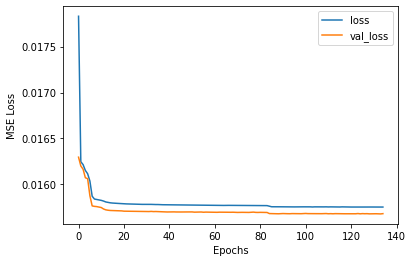

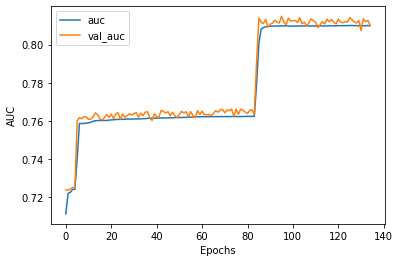

2726/2726 [==============================] - 1s 497us/step
The classifications using the MAD method on validation set with threshold=1.1800000000000006 are as follows:
    [[66777 18495]
 [ 1088   868]]
    # % of transactions labeled as fraud that were correct (precision): 868/(18495+868) = 4.48%
    # % of fraudulent transactions were caught succesfully (recall):    868/(1088+868) = 44.38%
Balanced accuracy =  0.6134343036242882
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     85272
           1       0.04      0.44      0.08      1956

    accuracy                           0.78     87228
   macro avg       0.51      0.61      0.48     87228
weighted avg       0.96      0.78      0.85     87228

ROC_AUC =  0.6523150218590777
2672/2672 [==============================] - 1s 512us/step
The classifications using the MAD method on validation set with threshold=1.1800000000000006 are as follows:
    [[66606 18667]
 [  120    98]]
    #

In [17]:
#train model 
X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=1)
history = autoencoder.fit(
    X_train_train_transformed, X_train_train_transformed,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=cb,
    validation_data=(X_train_validate_transformed, X_train_validate_transformed))
functions14.plot_metrics(history)

#Interpret training results ationsutoencoder 
functions14.get_results_autoencoder(X_validate_transformed, X_test_transformed, y_validate['Is_lost_item'], y_test['Is_lost_item'], autoencoder)

#Get latent representations 
AE_encoder = tf.keras.models.Sequential(autoencoder.layers[:latent_representation_number])
print(AE_encoder.summary())
AE_latent_representations_validate = pd.DataFrame(AE_encoder.predict(X_validate_transformed))
AE_latent_representations_test = pd.DataFrame(AE_encoder.predict(X_test_transformed))

#Get reconstruction errors
df_AE_reconstructions_validate = pd.DataFrame(autoencoder.predict(X_validate_transformed))
df_AE_reconstructions_test = pd.DataFrame(autoencoder.predict(X_test_transformed))

AE_reconstructions_validate = autoencoder.predict(X_validate_transformed)
AE_reconstructions_test = autoencoder.predict(X_test_transformed)
AE_reconstruction_error_validate_mae = X_validate_transformed - AE_reconstructions_validate
AE_reconstruction_error_validate_mse = np.power(X_validate_transformed - AE_reconstructions_validate,2)
AE_reconstruction_error_test_mae = X_test_transformed - AE_reconstructions_test
AE_reconstruction_error_test_mse = np.power(X_test_transformed - AE_reconstructions_test,2)

### 1.2 Create and train optimal VAE

In [24]:
#Set parameters autoencoder 
optimizer = 'Adam'
loss = 'mse'
activation_1 = 'sigmoid'
activation_2 = 'elu'
batch_size = 1500
hidden_layers = 3
nodes_start = 8
dropout_rate = 0.5
places_dropout = 1
amount_of_features = 25
input_dim = amount_of_features
latent_dim = 4
epochs = 100
latent_representation_number = 2

#Get the corresponding data
X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test =change_input_data(X_train_transformed, X_validate_transformed, X_test_transformed, y_test, y_validate, input_dim)

#create model
vae = functions14.create_vae(optimizer, loss, activation_1, activation_2, batch_size, hidden_layers, 
                             nodes_start, dropout_rate, places_dropout, input_dim, latent_dim)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 25)           650         ['input_6[0][0]']                
                                                                                                  
 dense_21 (Dense)               (None, 8)            208         ['dense_20[0][0]']               
                                                                                                  
 dropout_4 (Dropout)            (None, 8)            0           ['dense_21[0][0]']               
                                                                                            

Epoch 1/100
(None, 25)
(None, 25)
(None, 25)
(None, 25)
451/455 [============================>.] - ETA: 0s - loss: 39.9054 - mse: 0.0388 - auc: 0.7350(None, 25)
(None, 25)
455/455 [==============================] - 2s 3ms/step - loss: 39.6042 - mse: 0.0385 - auc: 0.7358 - val_loss: 2.7992 - val_mse: 0.0020 - val_auc: 0.8455
Epoch 2/100
455/455 [==============================] - 1s 3ms/step - loss: 3.3836 - mse: 0.0026 - auc: 0.8442 - val_loss: 2.7068 - val_mse: 0.0019 - val_auc: 0.8520
Epoch 3/100
455/455 [==============================] - 1s 3ms/step - loss: 2.9773 - mse: 0.0022 - auc: 0.8528 - val_loss: 2.6867 - val_mse: 0.0019 - val_auc: 0.8573
Epoch 4/100
455/455 [==============================] - 1s 3ms/step - loss: 2.8248 - mse: 0.0020 - auc: 0.8554 - val_loss: 2.6788 - val_mse: 0.0019 - val_auc: 0.8574
Epoch 5/100
455/455 [==============================] - 1s 3ms/step - loss: 2.7471 - mse: 0.0019 - auc: 0.8565 - val_loss: 2.6772 - val_mse: 0.0019 - val_auc: 0.8576
Epoch 6/100
45

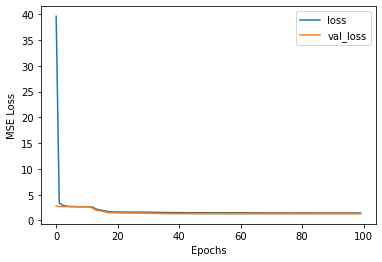

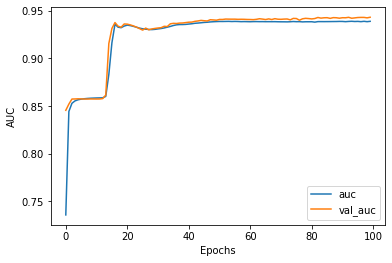

2726/2726 [==============================] - 1s 514us/step
The classifications using the MAD method on validation set with threshold=1.0100000000000005 are as follows:
    [[60218 25054]
 [ 1147   809]]
    # % of transactions labeled as fraud that were correct (precision): 809/(25054+809) = 3.13%
    # % of fraudulent transactions were caught succesfully (recall):    809/(1147+809) = 41.36%
Balanced accuracy =  0.5598932207984612
              precision    recall  f1-score   support

           0       0.98      0.71      0.82     85272
           1       0.03      0.41      0.06      1956

    accuracy                           0.70     87228
   macro avg       0.51      0.56      0.44     87228
weighted avg       0.96      0.70      0.80     87228

ROC_AUC =  0.5753111515542901
2672/2672 [==============================] - 1s 514us/step
The classifications using the MAD method on validation set with threshold=1.0100000000000005 are as follows:
    [[60184 25089]
 [  140    78]]
    #

In [25]:
history_vae = vae.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed))
functions14.plot_metrics(history_vae)

#Interpret training results ationsutoencoder 
functions14.get_results_autoencoder(X_validate_transformed, X_test_transformed, y_validate['Is_lost_item'], y_test['Is_lost_item'], vae)

#Get latent representations 
VAE_encoder = tf.keras.models.Sequential(vae.layers[:latent_representation_number])
print(VAE_encoder.summary())
VAE_latent_representations_validate = pd.DataFrame(VAE_encoder.predict(X_validate_transformed))
VAE_latent_representations_test = pd.DataFrame(VAE_encoder.predict(X_test_transformed))

#Get reconstruction errors
VAE_reconstructions_validate = vae.predict(X_validate_transformed)
VAE_reconstructions_test = vae.predict(X_test_transformed)
VAE_reconstruction_error_validate_mae = X_validate_transformed - VAE_reconstructions_validate
VAE_reconstruction_error_validate_mse = np.power(X_validate_transformed - VAE_reconstructions_validate,2)
VAE_reconstruction_error_test_mae = X_test_transformed - VAE_reconstructions_test
VAE_reconstruction_error_test_mse = np.power(X_test_transformed - VAE_reconstructions_test,2)

### 1.3 Create and train optimal DAE

In [22]:
#Set parameters autoencoder 
optimizer = 'Adam'
loss = 'mse'
activation_1 = 'sigmoid'
activation_2 = 'elu'
batch_size = 1000
hidden_layers = 3
nodes_start = 8
dropout_rate = 0.5
places_dropout = 1
amount_of_features = 25
input_dim = amount_of_features
epochs = 100
latent_representation_number = 5
stdev = 0.1

#Get the corresponding data
X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test =change_input_data(X_train_transformed, X_validate_transformed, X_test_transformed, y_test, y_validate, input_dim)
X_train_transformed_n = functions14.gaussian_noise(X_train_transformed, 0, stdev)
X_validate_transformed_n = functions14.gaussian_noise(X_validate_transformed, 0, stdev)
X_test_transformed_n = functions14.gaussian_noise(X_test_transformed, 0, stdev)

#create model
dae = functions14.create_model_(optimizer, loss, activation_1, activation_2, batch_size, hidden_layers, 
                  nodes_start, dropout_rate, places_dropout, input_dim)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_15 (Dense)            (None, 25)                650       
                                                                 
 dense_16 (Dense)            (None, 8)                 208       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 4)                 36        
                                                                 
 dense_18 (Dense)            (None, 8)                 40        
                                                                 
 dense_19 (Dense)            (None, 25)                225 

Epoch 1/100
683/683 [==============================] - 2s 2ms/step - loss: 0.0302 - mse: 0.0302 - auc: 0.7387 - accuracy: 0.6033 - val_loss: 0.0020 - val_mse: 0.0020 - val_auc: 0.8049 - val_accuracy: 0.7112
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 0.0023 - mse: 0.0023 - auc: 0.8292 - accuracy: 0.7062 - val_loss: 0.0019 - val_mse: 0.0019 - val_auc: 0.8572 - val_accuracy: 0.7112
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 0.0020 - mse: 0.0020 - auc: 0.8540 - accuracy: 0.7085 - val_loss: 0.0018 - val_mse: 0.0018 - val_auc: 0.8574 - val_accuracy: 0.7112
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 0.0019 - mse: 0.0019 - auc: 0.8564 - accuracy: 0.7085 - val_loss: 0.0019 - val_mse: 0.0019 - val_auc: 0.8573 - val_accuracy: 0.7112
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 0.0019 - mse: 0.0019 - auc: 0.8574 - accuracy: 0.7085 - val_loss: 0.0018 - val_mse: 0.0018 - val_

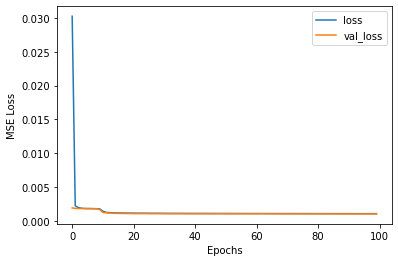

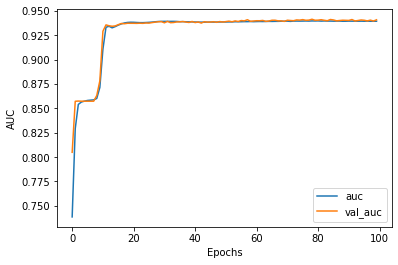

2726/2726 [==============================] - 1s 510us/step
The classifications using the MAD method on validation set with threshold=1.3300000000000007 are as follows:
    [[67375 17897]
 [ 1265   691]]
    # % of transactions labeled as fraud that were correct (precision): 691/(17897+691) = 3.72%
    # % of fraudulent transactions were caught succesfully (recall):    691/(1265+691) = 35.33%
Balanced accuracy =  0.5716953313453247
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     85272
           1       0.04      0.35      0.07      1956

    accuracy                           0.78     87228
   macro avg       0.51      0.57      0.47     87228
weighted avg       0.96      0.78      0.86     87228

ROC_AUC =  0.6144196204768343
2672/2672 [==============================] - 1s 492us/step
The classifications using the MAD method on validation set with threshold=1.3300000000000007 are as follows:
    [[67130 18143]
 [  140    78]]
    #

In [23]:
history_dae = dae.fit(
    X_train_transformed_n, X_train_transformed,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=cb,
    validation_data=(X_validate_transformed_n, X_validate_transformed))
functions14.plot_metrics(history_dae)

#Interpret training results ationsutoencoder 
functions14.get_results_autoencoder(X_validate_transformed, X_test_transformed, y_validate['Is_lost_item'], y_test['Is_lost_item'], dae)

#Get latent representations 
DAE_encoder = tf.keras.models.Sequential(dae.layers[:latent_representation_number])
print(DAE_encoder.summary())
DAE_latent_representations_validate = pd.DataFrame(DAE_encoder.predict(X_validate_transformed))
DAE_latent_representations_test = pd.DataFrame(DAE_encoder.predict(X_test_transformed))

#Get reconstruction errors
DAE_reconstructions_validate = dae.predict(X_validate_transformed)
DAE_reconstructions_test = dae.predict(X_test_transformed)
DAE_reconstruction_error_validate_mae = X_validate_transformed - DAE_reconstructions_validate
DAE_reconstruction_error_validate_mse = np.power(X_validate_transformed - DAE_reconstructions_validate, 2)
DAE_reconstruction_error_test_mae = X_test_transformed - DAE_reconstructions_test
DAE_reconstruction_error_test_mse = np.power(X_test_transformed - DAE_reconstructions_test, 2)

# 2. Supervised classifiers that reconstruction error as input 

## 2.1 Random Forest

### 2.1.1 Latent representation as input 

C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\1559080196.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


72074.48


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


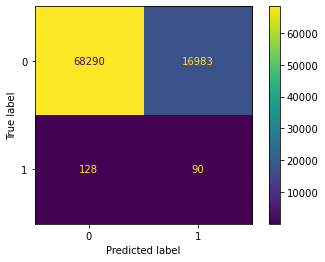

[[68290 16983]
 [  128    90]]
Test set results: Recall = 0.41284403669724773, Precision = 0.005271481286241434, ROC_AUC = 0.6464716882862026, balanced accuracy = 0.6068418464301971,  Costs are 72074.48
--- 54.23312759399414 seconds ---


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\1559080196.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


73245.92


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


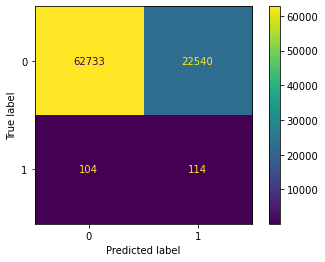

[[62733 22540]
 [  104   114]]
Test set results: Recall = 0.5229357798165137, Precision = 0.005032223889820782, ROC_AUC = 0.6641329084773275, balanced accuracy = 0.6293041335023606,  Costs are 73245.92
--- 18.200374126434326 seconds ---


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\1559080196.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


71118.02


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


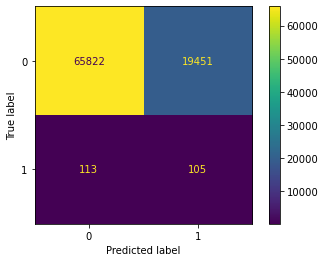

[[65822 19451]
 [  113   105]]
Test set results: Recall = 0.481651376146789, Precision = 0.00536919615463285, ROC_AUC = 0.671128519013461, balanced accuracy = 0.6267743470862122,  Costs are 71118.02
--- 16.499786853790283 seconds ---


In [50]:
random_state = 1
model_RF = RandomForestClassifier(random_state=random_state)

param_grid = {
    'criterion': ['entropy'],
    'max_depth': [5, None],
    'max_features': [2, 5, None],
    'min_samples_split': [5, None],
    'n_estimators': [100, 500],
    'class_weight': ['balanced']}

#LATENT REPRESENTATION AS INPUT results 
#Autoencoder
#best_params_AE = find_optimal_parameters(model_RF, param_grid, cost_scorer, 3, AE_latent_representations_validate, y_validate)
start_time = time.time()
best_params_AE_RF = {'n_estimators': 200, 'min_samples_split': 5, 'max_features': None,
                     'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
evaluate_DH_performance('RF', best_params_AE_RF, AE_latent_representations_validate, y_validate, AE_latent_representations_test, y_test)   
print("--- %s seconds ---" % (time.time() - start_time))

# #VAE
start_time = time.time()
# best_params_VAE = find_optimal_parameters(model_RF, param_grid, 'roc_auc', 3, VAE_latent_representations_validate, y_validate)
evaluate_DH_performance('RF', best_params_VAE_RF, VAE_latent_representations_validate, y_validate, VAE_latent_representations_test, y_test)   
print("--- %s seconds ---" % (time.time() - start_time))

# #DAE
start_time = time.time()
# best_params_DAE = find_optimal_parameters(model_RF, param_grid, 'roc_auc', 3, DAE_latent_representations_validate, y_validate)
evaluate_DH_performance('RF', best_params_DAE_RF, DAE_latent_representations_validate, y_validate, DAE_latent_representations_test, y_test) 
print("--- %s seconds ---" % (time.time() - start_time))

### 2.1.2 Reconstruction error as input 

C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\770339783.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


54283.68


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


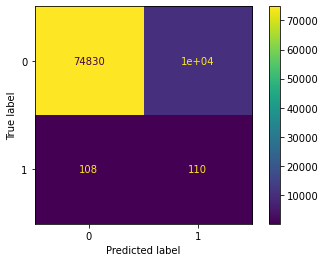

[[74830 10443]
 [  108   110]]
Test set results: Recall = 0.5045871559633027, Precision = 0.010423576234246185, ROC_AUC = 0.7425179593183556, balanced accuracy = 0.6910608313912887,  Costs are 54283.68


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\770339783.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_optimized.fit(X_validate, y_validate)


Total misclassification costs are  51140.82000000001
TN    74830
FP    10443
TP      110
FN      108
Name: classification, dtype: int64


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\770339783.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


54247.92


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


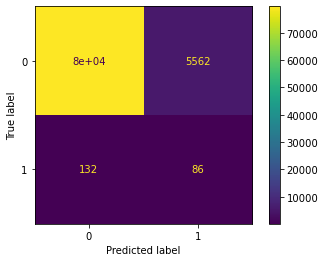

[[79711  5562]
 [  132    86]]
Test set results: Recall = 0.3944954128440367, Precision = 0.015226628895184136, ROC_AUC = 0.7323293121057388, balanced accuracy = 0.6646348043310869,  Costs are 54247.92


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\770339783.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_optimized.fit(X_validate, y_validate)


Total misclassification costs are  76721.37000000007
TN    79711
FP     5562
FN      132
TP       86
Name: classification, dtype: int64


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\770339783.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


54664.72


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


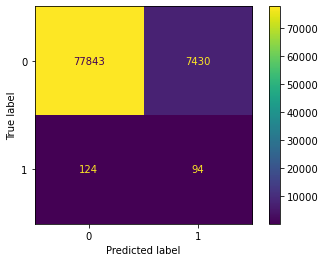

[[77843  7430]
 [  124    94]]
Test set results: Recall = 0.43119266055045874, Precision = 0.012493354598617756, ROC_AUC = 0.7283857178837487, balanced accuracy = 0.672030371530961,  Costs are 54664.72


C:\Users\jan.deleeuw\AppData\Local\Temp\ipykernel_12192\770339783.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_optimized.fit(X_validate, y_validate)


Total misclassification costs are  78028.08000000007
TN    77843
FP     7430
FN      124
TP       94
Name: classification, dtype: int64


78028.08000000007

In [68]:
# RECONSTRUCTION ERROR AS INPUT 
random_state = 1
model_RF = RandomForestClassifier(random_state=random_state)

param_grid = {
    'criterion': ['entropy'],
    'max_depth': [5,10, None],
    'max_features': [2, 5, None],
    'min_samples_split': [5, 10, None],
    'n_estimators': [100, 500],
    'class_weight': ['balanced', None]}

#Autoencoder MSE
#best_params_AE = find_optimal_parameters(model_RF, param_grid, 'balanced_accuracy', 3, AE_reconstruction_error_validate_mse, y_validate)
best_params_AE_RF = {'n_estimators': 100, 'min_samples_split': 10, 'max_features': None, 'max_depth': 5, 
                     'criterion': 'entropy', 'class_weight': 'balanced'}
#evaluate_DH_performance('RF', best_params_AE_RF, AE_reconstruction_error_validate_mse, y_validate,
#                        AE_reconstruction_error_test_mse, y_test)  
X_test_, y_test, y_pred = get_outcomes('RF', best_params_AE_RF, AE_reconstruction_error_validate_mse, y_validate,
                        AE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

#Autoencoder MAE
#evaluate_DH_performance('RF', best_params_AE_RF, AE_reconstruction_error_validate_mae, y_validate,
#                        AE_reconstruction_error_test_mae, y_test)   

#VAE MSE
# start_time = time.time()
# #evaluate_DH_performance('RF', best_params_VAE_RF, VAE_reconstruction_error_validate_mse, y_validate,
# #                        VAE_reconstruction_error_test_mse, y_test)   
X_test_, y_test, y_pred = get_outcomes('RF', best_params_VAE_RF, VAE_reconstruction_error_validate_mse, y_validate,
                        VAE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)
# print("--- %s seconds ---" % (time.time() - start_time))

#VAE MAE
#evaluate_DH_performance('RF', best_params_VAE_RF, VAE_reconstruction_error_validate_mae, y_validate,
#                        VAE_reconstruction_error_test_mae, y_test)   

#DAE MSE
# start_time = time.time()
# #evaluate_DH_performance('RF', best_params_DAE_RF, DAE_reconstruction_error_validate_mse, y_validate,
# #                        DAE_reconstruction_error_test_mse, y_test)   
X_test_, y_test, y_pred = get_outcomes('RF', best_params_DAE_RF, DAE_reconstruction_error_validate_mse, y_validate,
                        DAE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)
# print("--- %s seconds ---" % (time.time() - start_time))

#DAE MAE
#evaluate_DH_performance('RF', best_params_DAE_RF, DAE_reconstruction_error_validate_mae, y_validate,
#                        DAE_reconstruction_error_test_mae, y_test)   

## 2.2 Logistic Regression

### 2.2.1 Latent representation as input 

C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100771.16


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


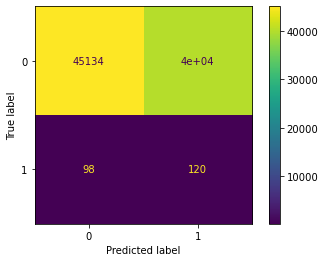

[[45134 40139]
 [   98   120]]
Test set results: Recall = 0.5504587155963303, Precision = 0.0029806999677090837, ROC_AUC = 0.575903221568891, balanced accuracy = 0.5398735007273455,  Costs are 100771.16


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


86945.94


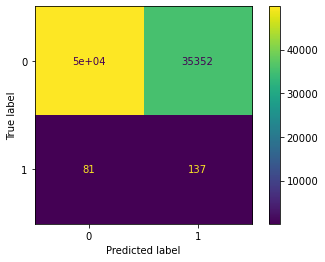

[[49921 35352]
 [   81   137]]
Test set results: Recall = 0.6284403669724771, Precision = 0.0038603510947054017, ROC_AUC = 0.6644197906411109, balanced accuracy = 0.6069329999697679,  Costs are 86945.94


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


79278.06


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


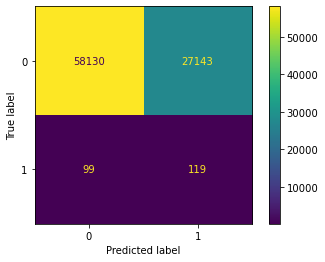

[[58130 27143]
 [   99   119]]
Test set results: Recall = 0.5458715596330275, Precision = 0.004365050253099552, ROC_AUC = 0.6620532952071796, balanced accuracy = 0.6137822376636635,  Costs are 79278.06


In [45]:
lr = LogisticRegression(random_state = random_state)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'lbfgs', 'saga']}

#LATENT REPRESENTATION AS INPUT results 
#Autoencoder
#best_params_AE = find_optimal_parameters(lr, param_grid, 'roc_auc', 3, AE_latent_representations_validate, y_validate)
evaluate_DH_performance('LR', best_params_AE_LR, AE_latent_representations_validate, y_validate, AE_latent_representations_test, y_test)

#VAE
#best_params_VAE = find_optimal_parameters(lr, param_grid, 'roc_auc', 3, VAE_latent_representations_validate, y_validate)
evaluate_DH_performance('LR', best_params_VAE_LR, VAE_latent_representations_validate, y_validate, VAE_latent_representations_test, y_test)

#DAE
#best_params_DAE = find_optimal_parameters(lr, param_grid, 'roc_auc', 3, DAE_latent_representations_validate, y_validate)
evaluate_DH_performance('LR', best_params_DAE_LR, DAE_latent_representations_validate, y_validate, DAE_latent_representations_test, y_test)

### 2.2.2 Reconstruction error as input 

C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


74591.52


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


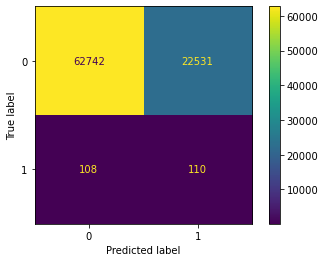

[[62742 22531]
 [  108   110]]
Test set results: Recall = 0.5045871559633027, Precision = 0.00485844264829292, ROC_AUC = 0.6694573618223694, balanced accuracy = 0.6201825932619862,  Costs are 74591.52


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


70857.98


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


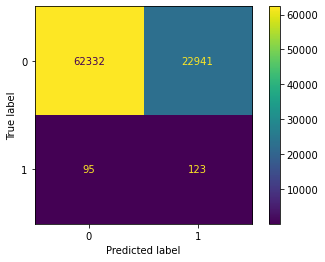

[[62332 22941]
 [   95   123]]
Test set results: Recall = 0.5642201834862385, Precision = 0.0053329864724245574, ROC_AUC = 0.7046025517396528, balanced accuracy = 0.6475950635395847,  Costs are 70857.98


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


69355.70000000001


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


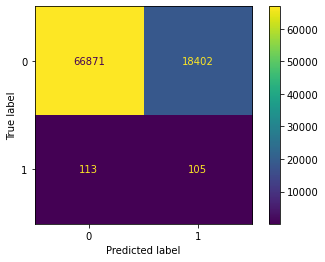

[[66871 18402]
 [  113   105]]
Test set results: Recall = 0.481651376146789, Precision = 0.005673528934997569, ROC_AUC = 0.6706366825942841, balanced accuracy = 0.6329251802925026,  Costs are 69355.70000000001


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


71757.4


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


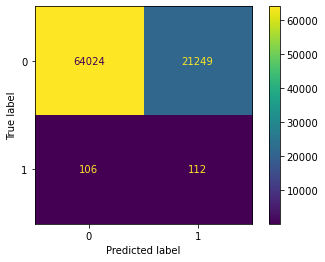

[[64024 21249]
 [  106   112]]
Test set results: Recall = 0.5137614678899083, Precision = 0.005243200224708581, ROC_AUC = 0.6738111066271016, balanced accuracy = 0.6322867827529004,  Costs are 71757.4


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


71991.34


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


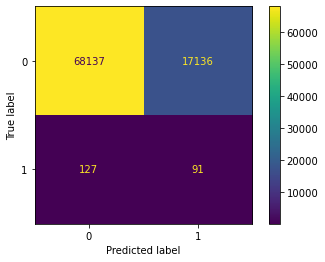

[[68137 17136]
 [  127    91]]
Test set results: Recall = 0.41743119266055045, Precision = 0.005282405526208858, ROC_AUC = 0.6498253262565121, balanced accuracy = 0.6082383057459168,  Costs are 71991.34


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


73687.18


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


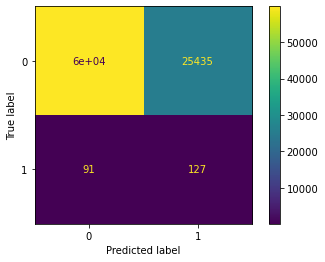

[[59838 25435]
 [   91   127]]
Test set results: Recall = 0.5825688073394495, Precision = 0.00496831233862765, ROC_AUC = 0.7060952750028859, balanced accuracy = 0.6421457548594331,  Costs are 73687.18


In [32]:
# RECONSTRUCTION ERROR AS INPUT 
random_state = 1
lr = LogisticRegression(random_state = random_state)

#Autoencoder MSE
#best_params_AE = find_optimal_parameters(lr, param_grid, 'roc_auc', 3, AE_reconstruction_error_validate_mae, y_validate)
#evaluate_DH_performance('LR', best_params_AE_LR, AE_reconstruction_error_validate_mse, y_validate,
#                        AE_reconstruction_error_test_mse, y_test)
X_test, y_test, y_pred = get_outcomes('LR', best_params_AE_LR, AE_reconstruction_error_validate_mse, y_validate,
                        AE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

# #Autoencoder MAE
# evaluate_DH_performance('LR', best_params_AE_LR, AE_reconstruction_error_validate_mae, y_validate,
#                         AE_reconstruction_error_test_mae, y_test)   

#VAE MSE
# evaluate_DH_performance('LR', best_params_VAE_LR, VAE_reconstruction_error_validate_mse, y_validate,
#                         VAE_reconstruction_error_test_mse, y_test)   
X_test, y_test, y_pred = get_outcomes('LR', best_params_VAE_LR, VAE_reconstruction_error_validate_mse, y_validate,
                        VAE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

# #VAE MAE
# evaluate_DH_performance('LR', best_params_VAE_LR, VAE_reconstruction_error_validate_mae, y_validate,
#                         VAE_reconstruction_error_test_mae, y_test)   

#DAE MSE
# evaluate_DH_performance('LR', best_params_DAE_LR, DAE_reconstruction_error_validate_mse, y_validate,
#                         DAE_reconstruction_error_test_mse, y_test)   
X_test, y_test, y_pred = get_outcomes('LR', best_params_DAE_LR, DAE_reconstruction_error_validate_mse, y_validate,
                        DAE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

# #DAE MAE
# evaluate_DH_performance('LR', best_params_DAE_LR, DAE_reconstruction_error_validate_mae, y_validate,
#                         DAE_reconstruction_error_test_mae, y_test)   

## 2.3 SVM

### 2.3.1 Latent representation as input

In [ ]:
#Regular SVM
param_grid = {
    'C': [1],
    'kernel': ['linear', 'rbf ', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']}

svc = SVC(probability=True, random_state=random_state)

#Autoencoder
#best_params_AE = find_optimal_parameters(svc, param_grid, 'roc_auc', 3, AE_latent_representations_validate, y_validate)
evaluate_DH_performance('svm', best_params_AE_SVM, AE_latent_representations_validate, y_validate, AE_latent_representations_test, y_test)

#VAE
#best_params_VAE = find_optimal_parameters(svc, param_grid, 'roc_auc', 3, VAE_latent_representations_validate, y_validate)
evaluate_DH_performance('svm', best_params_VAE_SVM, VAE_latent_representations_validate, y_validate, VAE_latent_representations_test, y_test)

#DAE
#best_params_DAE = find_optimal_parameters(svc, param_grid, 'roc_auc', 3, DAE_latent_representations_validate, y_validate)
evaluate_DH_performance('svm', best_params_DAE_SVM, DAE_latent_representations_validate, y_validate, DAE_latent_representations_test, y_test)

### 2.3.2 Reconstruction error as input 

In [ ]:
# RECONSTRUCTION ERROR AS INPUT 
random_state = 1
svc = SVC(probability=True, random_state=random_state)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'lbfgs', 'saga']}

#Reconstruction error AS INPUT results 
#Autoencoder MSE
#best_params_AE = find_optimal_parameters(svc, param_grid, 'roc_auc', 3, AE_reconstruction_error_validate_mse, y_validate)
print('params used are ', best_params_AE_SVM)
#evaluate_DH_performance('svm', best_params_AE_SVM, AE_reconstruction_error_validate_mse, y_validate,
#                        AE_reconstruction_error_test_mse, y_test)   
#Autoencoder MAE
#evaluate_DH_performance('svm', best_params_AE_SVM, AE_reconstruction_error_validate_mae, y_validate,
#                        AE_reconstruction_error_test_mae, y_test)   
#VAE MSE
evaluate_DH_performance('svm', best_params_VAE_SVM, VAE_reconstruction_error_validate_mse, y_validate,
                        VAE_reconstruction_error_test_mse, y_test)   
#VAE MAE
evaluate_DH_performance('svm', best_params_VAE_SVM, VAE_reconstruction_error_validate_mae, y_validate,
                        VAE_reconstruction_error_test_mae, y_test)   
#DAE MSE
evaluate_DH_performance('svm', best_params_DAE_SVM, DAE_reconstruction_error_validate_mse, y_validate,
                        DAE_reconstruction_error_test_mse, y_test)   
#DAE MAE
evaluate_DH_performance('svm', best_params_DAE_SVM, DAE_reconstruction_error_validate_mae, y_validate,
                        DAE_reconstruction_error_test_mae, y_test)   

## 2.4 XGBoost

### 2.4.1 Latent representation as input

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'tree_method': 'approx', 'subsample': 1, 'scale_pos_weight': 100, 'sampling_method': 'uniform', 'max_depth': 5, 'lambda': 1, 'gamma': 10, 'eta': 0.4, 'booster': 'dart', 'alpha': 1}
best score is  0.6433693936890222
99500.16


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


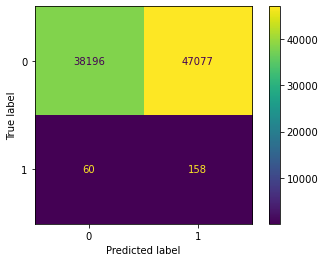

[[38196 47077]
 [   60   158]]
Test set results: Recall = 0.7247706422018348, Precision = 0.003344977241452313, ROC_AUC = 0.6470008844771304, balanced accuracy = 0.5863483574664727,  Costs are 99500.16
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'tree_method': 'auto', 'subsample': 1, 'scale_pos_weight': 1, 'sampling_method': 'uniform', 'max_depth': 5, 'lambda': 1, 'gamma': 10, 'eta': 0.4, 'booster': 'gbtree', 'alpha': 1}
best score is  0.6570260892318885
74169.32


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


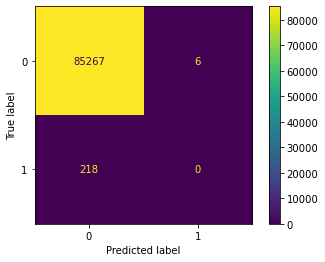

[[85267     6]
 [  218     0]]
Test set results: Recall = 0.0, Precision = 0.0, ROC_AUC = 0.6620022718184025, balanced accuracy = 0.4999648188758458,  Costs are 74169.32
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'tree_method': 'auto', 'subsample': 1, 'scale_pos_weight': 1, 'sampling_method': 'uniform', 'max_depth': 5, 'lambda': 1, 'gamma': 10, 'eta': 0.4, 'booster': 'gbtree', 'alpha': 1}
best score is  0.6593970658022801


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


74159.24


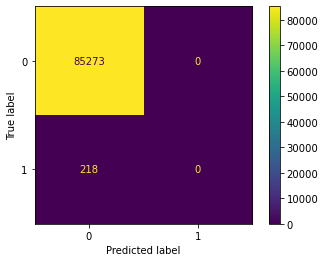

[[85273     0]
 [  218     0]]
Test set results: Recall = 0.0, Precision = 0.0, ROC_AUC = 0.6716550255159979, balanced accuracy = 0.5,  Costs are 74159.24


In [47]:
random_state =1
xgb = XGBClassifier(random_state=random_state) 

param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.4],
    'gamma': [10,50],
    'max_depth': [5, None],
    'subsample': [1],
    'sampling_method': ['uniform', 'gradient_based'],
    'lambda': [1],
    'alpha': [1],
    'tree_method': ['auto', 'approx'],
    'scale_pos_weight': [1, 100]} #Check for undersampling if this still works?

#Autoencoder
best_params_AE = find_optimal_parameters(xgb, param_grid, 'roc_auc', 3, AE_latent_representations_validate, y_validate)
evaluate_DH_performance('XGB', best_params_AE, AE_latent_representations_validate, y_validate, AE_latent_representations_test, y_test)   

#VAE
best_params_VAE = find_optimal_parameters(xgb, param_grid, 'roc_auc', 3, VAE_latent_representations_validate, y_validate)
evaluate_DH_performance('XGB', best_params_VAE, VAE_latent_representations_validate, y_validate, VAE_latent_representations_test, y_test)   

# #DAE
best_params_DAE = find_optimal_parameters(xgb, param_grid, 'roc_auc', 3, DAE_latent_representations_validate, y_validate)
evaluate_DH_performance('XGB', best_params_DAE, DAE_latent_representations_validate, y_validate, DAE_latent_representations_test, y_test)   

### 2.4.2 Reconstruction error as input 

51930.92


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


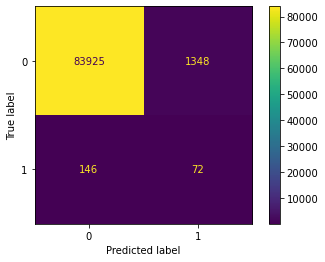

[[83925  1348]
 [  146    72]]
Test set results: Recall = 0.3302752293577982, Precision = 0.05070422535211268, ROC_AUC = 0.7573336505731134, balanced accuracy = 0.6572335887855918,  Costs are 51930.92
--- 0.5255265235900879 seconds ---
51930.92


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


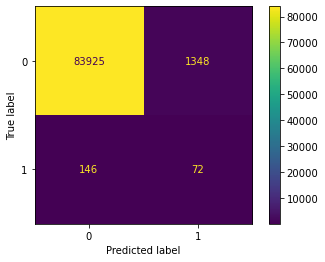

[[83925  1348]
 [  146    72]]
Test set results: Recall = 0.3302752293577982, Precision = 0.05070422535211268, ROC_AUC = 0.7573336505731134, balanced accuracy = 0.6572335887855918,  Costs are 51930.92
Total misclassification costs are  72532.07000000007
TN    83925
FP     1348
FN      146
TP       72
Name: classification, dtype: int64
52680.159999999996


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


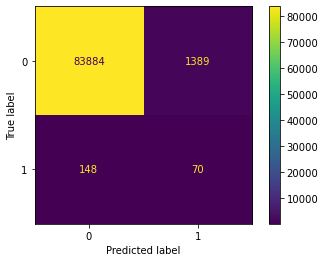

[[83884  1389]
 [  148    70]]
Test set results: Recall = 0.3211009174311927, Precision = 0.047978067169294036, ROC_AUC = 0.7318349473794743, balanced accuracy = 0.652406028473902,  Costs are 52680.159999999996
Total misclassification costs are  73144.12000000004
TN    83884
FP     1389
FN      148
TP       70
Name: classification, dtype: int64
54189.54


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


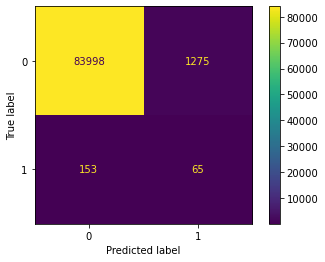

[[83998  1275]
 [  153    65]]
Test set results: Recall = 0.2981651376146789, Precision = 0.048507462686567165, ROC_AUC = 0.7248756476366192, balanced accuracy = 0.6416065799245747,  Costs are 54189.54
Total misclassification costs are  72377.64000000004
TN    83998
FP     1275
FN      153
TP       65
Name: classification, dtype: int64


72377.64000000004

In [69]:
random_state = 1
xgb = XGBClassifier(random_state=random_state) 


#Autoencoder MSE
#best_params_AE = find_optimal_parameters(xgb, param_grid, 'roc_auc', 3, AE_reconstruction_error_validate_mse, y_validate)
start_time = time.time()
evaluate_DH_performance('XGB', best_params_AE_XGB, AE_reconstruction_error_validate_mse, y_validate,
                        AE_reconstruction_error_test_mse, y_test)   
print("--- %s seconds ---" % (time.time() - start_time))

X_test_, y_test, y_pred = get_outcomes('XGB', best_params_AE_XGB, AE_reconstruction_error_validate_mse, y_validate,
                        AE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

#Autoencoder MAE
# evaluate_DH_performance('XGB', best_params_AE_XGB, AE_reconstruction_error_validate_mae, y_validate,
#                         AE_reconstruction_error_test_mae, y_test)   
# #VAE MSE
# evaluate_DH_performance('XGB', best_params_VAE_XGB, VAE_reconstruction_error_validate_mse, y_validate,
#                         VAE_reconstruction_error_test_mse, y_test)   

X_test_, y_test, y_pred = get_outcomes('XGB', best_params_VAE_XGB, VAE_reconstruction_error_validate_mse, y_validate,
                        VAE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

# #VAE MAE
# evaluate_DH_performance('XGB', best_params_VAE_XGB, VAE_reconstruction_error_validate_mae, y_validate,
#                         VAE_reconstruction_error_test_mae, y_test)   
# #DAE MSE
# evaluate_DH_performance('XGB', best_params_DAE_XGB, DAE_reconstruction_error_validate_mse, y_validate,
#                         DAE_reconstruction_error_test_mse, y_test)   

X_test_, y_test, y_pred = get_outcomes('XGB', best_params_DAE_XGB, DAE_reconstruction_error_validate_mse, y_validate,
                        DAE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

# #DAE MAE
# evaluate_DH_performance('XGB', best_params_DAE_XGB, DAE_reconstruction_error_validate_mae, y_validate,
#                         DAE_reconstruction_error_test_mae, y_test)   

## 2.5 Decision Tree classifier 

### 2.5.1 Latent representation as input

In [ ]:
DT = DecisionTreeClassifier(random_state=random_state)

param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5,10, None],
    'max_features': [5, 10, None],
    'min_samples_split': [50, 150, None],
    'class_weight': ['balanced', None]}


#LATENT REPRESENTATION AS INPUT results 
#Autoencoder
best_params_AE = find_optimal_parameters(DT, param_grid, 'balanced_accuracy', 3, AE_latent_representations_validate, y_validate)
evaluate_DH_performance('DT', best_params_AE, AE_latent_representations_validate, y_validate, AE_latent_representations_test, y_test)

#VAE
best_params_VAE = find_optimal_parameters(DT, param_grid, 'roc_auc', 3, VAE_latent_representations_validate, y_validate)
evaluate_DH_performance('DT', best_params_VAE, VAE_latent_representations_validate, y_validate, VAE_latent_representations_test, y_test)

#DAE
best_params_DAE = find_optimal_parameters(DT, param_grid, 'roc_auc', 3, DAE_latent_representations_validate, y_validate)
evaluate_DH_performance('DT', best_params_DAE, DAE_latent_representations_validate, y_validate, DAE_latent_representations_test, y_test)

### 2.5.2 Reconstruction error as input 

61497.600000000006


C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


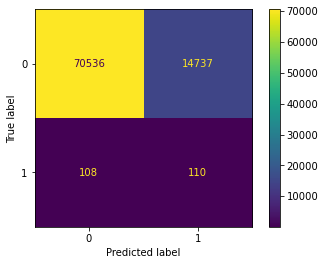

[[70536 14737]
 [  108   110]]
Test set results: Recall = 0.5045871559633027, Precision = 0.007408904155721694, ROC_AUC = 0.6966600364054704, balanced accuracy = 0.6658828735382754,  Costs are 61497.600000000006
Total misclassification costs are  61045.85
TN    70536
FP    14737
TP      110
FN      108
Name: classification, dtype: int64


61045.85

In [74]:
DT = DecisionTreeClassifier(random_state=random_state)

param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5,10, None],
    'max_features': [5, 10, None],
    'min_samples_split': [50, 150, None],
    'class_weight': ['balanced', None]}

#Autoencoder MSE
#best_params_AE = find_optimal_parameters(DT, param_grid, 'balanced_accuracy', 3, AE_reconstruction_error_validate_mse, y_validate)
#best_params_VAE = find_optimal_parameters(DT, param_grid, 'roc_auc', 3, VAE_reconstruction_error_validate_mse, y_validate)
#best_params_DAE = find_optimal_parameters(DT, param_grid, 'roc_auc', 3, DAE_reconstruction_error_validate_mse, y_validate)

#evaluate_DH_performance('DT', best_params_AE, AE_reconstruction_error_validate_mse, y_validate,
#                        AE_reconstruction_error_test_mse, y_test)   


X_test_, y_test, y_pred = get_outcomes('DT', best_params_AE_DT, AE_reconstruction_error_validate_mse, y_validate,
                        AE_reconstruction_error_test_mse, y_test)
cost_test_set(X_test, y_test, y_pred)

# #Autoencoder MAE
# evaluate_DH_performance('DT', best_params_AE, AE_reconstruction_error_validate_mae, y_validate,
#                         AE_reconstruction_error_test_mae, y_test)   
# #VAE MSE
# evaluate_DH_performance('DT', best_params_VAE, VAE_reconstruction_error_validate_mse, y_validate,
#                         VAE_reconstruction_error_test_mse, y_test)   
# #VAE MAE
# evaluate_DH_performance('DT', best_params_VAE, VAE_reconstruction_error_validate_mae, y_validate,
#                         VAE_reconstruction_error_test_mae, y_test)   
# #DAE MSE
# evaluate_DH_performance('DT', best_params_DAE, DAE_reconstruction_error_validate_mse, y_validate,
#                         DAE_reconstruction_error_test_mse, y_test)   
# #DAE MAE
# evaluate_DH_performance('DT', best_params_DAE, DAE_reconstruction_error_validate_mae, y_validate,
#                         DAE_reconstruction_error_test_mae, y_test)   

### 2.6 Insure everything and insure nothing

In [97]:
y_pred_0 = pd.DataFrame([0 for element in range(len(X_test_transformed))])
y_pred_1 = pd.DataFrame([1 for element in range(len(X_test_transformed))])                         
cost_test_set(X_test, y_test, y_pred_0)
cost_test_set(X_test, y_test, y_pred_1)

# test_df = merge_test_set(X_test['stock_value'], y_test, y_pred_0)
# test_df['Pred'] = test_df.iloc[:,-1:]
# test_df['stock_value_normal'] = np.exp(test_df["stock_value"]) 
# test_df['classification'] = test_df.apply(lambda x: determine_misclass(x.Pred, x.Is_lost_item), axis=1)
# test_df['misclass_cost'] = test_df.apply(lambda x: determine_misclass_cost(x.classification, x.stock_value_normal), axis=1)
# print('Total misclassification costs are ', np.sum(test_df['misclass_cost']))
# print(test_df['classification'].value_counts())

Total misclassification costs are  92157.57000000007
TN    85273
FN      218
Name: classification, dtype: int64
Total misclassification costs are  177299.05
FP    85273
TP      218
Name: classification, dtype: int64


177299.05

In [83]:
y_pred_0.shape

(85490, 1)

In [92]:
y_test.shape

(85491, 1)

(85490, 226)

In [91]:
X_test_transformed.shape

(85491, 25)